In the notebook *NS_sliding_window*, we have looked to the evolution of the SNR for a sliding window as a function of the sliding window. We have seen that there was an evolution with time and that more or less 25s before the time of the merger enters the window, it is possible to find a SNR that increases. Without noise added after, there is a SNR that increases but it does not give the correct time. However, if we just stick data without signal in it behind, it works well and the correct time can be found.

Here, we try to see if we can have the same type of behaviour for the H1 detector, where the signal is less strong. The analysis is looked at here.

**There is a problem with the H1 data when going further away of the event, leading to the explosion of the data**

In [1]:
#make beautiful plots

%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [14]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



### First, complete analysis of the signal to see if the event can be found

In [15]:
#get data around the event, 256 seconds that include the event 
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import sigma
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
import numpy 

merger = Merger("GW170817")

strains = {}
stildes = {}

for ifo in ['L1', 'H1']:
    # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strains[ifo] = highpass(ts, 15)

    # Remove time corrupted by the high pass filter
    strains[ifo] = strains[ifo].crop(4, 4)
    
    # Also create a frequency domain version of the data
    stildes[ifo] = strains[ifo].to_frequencyseries()

In [16]:
strain = strains['H1']
str_freq = stildes['H1']

Text(0.5,1,'PSD for the H1 detector')

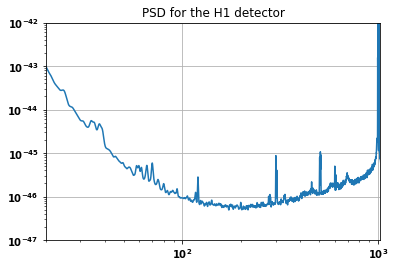

In [17]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = strain.psd(2)
psd = interpolate(psd, strain.delta_f)
psd = inverse_spectrum_truncation(psd, 2*strain.sample_rate, 
                                  low_frequency_cutoff = 15.0,
                                  trunc_method = 'hann')

plt.loglog(psd.sample_frequencies, psd)
plt.ylim(1e-47, 1e-42)
plt.xlim(20,1024)
plt.grid()
plt.title("PSD for the H1 detector")

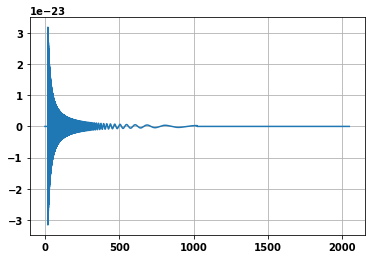

In [18]:
#make the template with the parameters that are found in paper (and graceDB)
from pycbc.waveform import get_fd_waveform

hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                         mass1 = 1.5270051, mass2 = 1.2422962, 
                         spin1z = -0.015901944, spin2z = -0.035747342,
                        distance = 85.493584, coa_phase = -2.0127285,
                        f_final = 1024.0, f_lower = 20., 
                        delta_f = str_freq.delta_f)

hp.resize(len(str_freq))

plt.plot(hp.sample_frequencies, hp)
plt.grid()

In [19]:
#matched filtering
from pycbc.filter import matched_filter
import numpy 

snr = matched_filter(hp, str_freq, psd = psd, 
                      low_frequency_cutoff = 15.0)

snr_z = snr.time_slice(merger.time - 1, merger.time + 1)
_, idx = snr.abs_max_loc()
max_snr = snr[idx]
snr_m = abs(max_snr)
max_t = float(idx)/snr.sample_rate + snr.start_time

print("We found a signal at %.7f with a SNR of %.7f" %(max_t, snr_m))
print(merger.time)

We found a signal at 1187008882.4456544 with a SNR of 14.0578594
1187008882.4


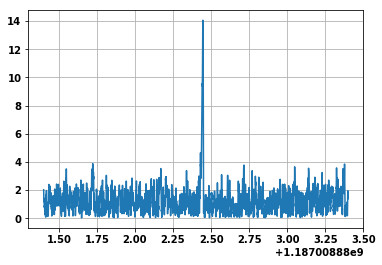

In [20]:
plt.plot(snr_z.sample_times, abs(snr_z))
plt.grid()

Text(0,0.5,'Normalized amplitude')

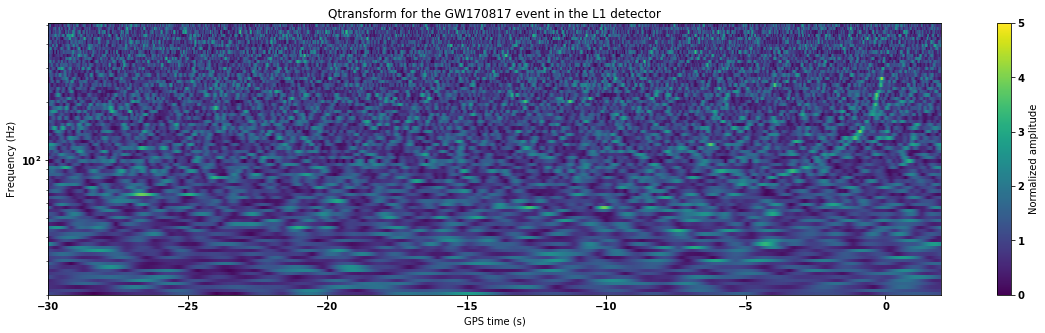

In [21]:
#visualisation of the data with the Q transform

hoft = (str_freq/psd**0.5).to_timeseries()
zoom = hoft.time_slice(merger.time - 30, merger.time + 2)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,1000), 
                         qrange = (110, 110))
plt.figure(figsize = [20,5])
im = plt.pcolormesh(t-merger.time, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Qtransform for the GW170817 event in the L1 detector")
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')

Text(0,0.5,'Normalized amplitude')

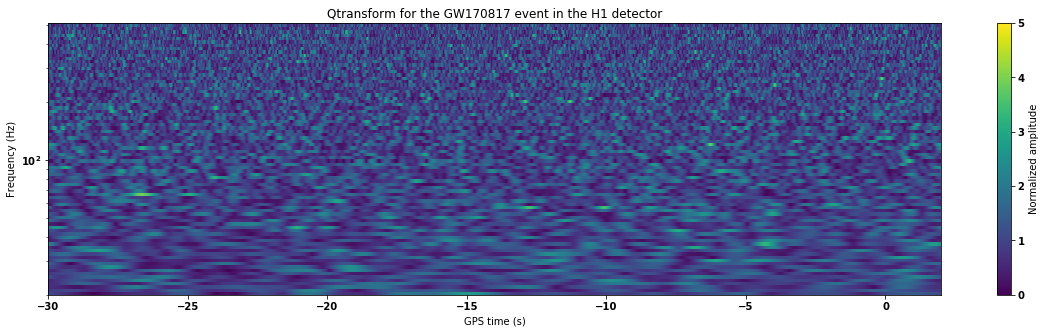

In [23]:
#we try to sibtract the data to see if it is well modeled.
#if the subtraction is well done, we can suppose that this is a good
#representation of the system and that it can be used for the search

from pycbc.filter import sigma

#shift of the template to the correct time
dt = max_t - str_freq.start_time
inj = hp.cyclic_time_shift(dt)

inj/= sigma(hp, psd = psd, low_frequency_cutoff = 15.0)
inj *= max_snr

st2 = str_freq - inj

hoft = (st2/psd**0.5).to_timeseries()

zoom = hoft.time_slice(merger.time - 30, merger.time + 2)

t, f, p = zoom.qtransform(.001, logfsteps = 100, frange = (20,1000), 
                         qrange = (110, 110))
plt.figure(figsize = [20,5])
im = plt.pcolormesh(t-merger.time, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Qtransform for the GW170817 event in the H1 detector")
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')

The signal seems to be well subtracted out of the data. So, the matched filtering for the full signal works well. We can thus look at how the signal evolves

## Variation of the signal as a function of the fraction of data that is considerred

In [56]:
import numpy as np

end_times = np.arange(-100, 50, 1)
start_times = np.arange(-356, -206, 1)
print(len(end_times), len(start_times))

(150, 150)


In [57]:
import numpy as np

snrs = []
times = []

end_times = np.arange(-100, 50., 1)
start_times = np.arange(-356, -206, 1)

result_file = open("NS_sliding_windowSNR_H1.txt", "w")



for i in range(len(start_times)):
    print("Itteration %i  / %i" %(i, len(end_times)))
    #download and prepare the data frame
    ts = read_frame("H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf",
                    'H1:LOSC-STRAIN',
                   start_time=merger.time + start_times[i],
                   end_time=merger.time + end_times[i],
                   check_integrity=False)
    strain = highpass(ts, 15)
    strain = strain.crop(4,4)
    str_freq = strain.to_frequencyseries()
    
    #psd of the data
    
    psd = strain.psd(2)
    psd = interpolate(psd, strain.delta_f)
    psd = inverse_spectrum_truncation(psd, 2*strain.sample_rate, 
                                           low_frequency_cutoff = 15.0,
                                          trunc_method = 'hann')
    
    #rebuild the template to be sure that it is the correct size
    
    hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                         mass1 = 1.5270051, mass2 = 1.2422962, 
                         spin1z = -0.015901944, spin2z = -0.035747342,
                        distance = 85.493584, coa_phase = -2.0127285,
                        f_final = 1024.0, f_lower = 20., 
                        delta_f = str_freq.delta_f)

    hp.resize(len(str_freq))
    
    #matched filtering
    snr = matched_filter(hp, str_freq, psd = psd, 
                         low_frequency_cutoff = 15.0)
    _, idx = snr.abs_max_loc()
    max_snr = snr[idx]
    snr_m = abs(max_snr)
    max_t = float(idx)/snr.sample_rate + snr.start_time
    
    snrs.append(snr_m)
    times.append(max_t)
    
    #write what is obtained into a text file
    result_file.write("start time: %i, end time: %.4f, SNR: %.7f found at time %.7f /n" %(start_times[i], (merger.time+end_times[i]), snr_m, max_t))
    
    print("Done")
    



Itteration 0  / 150
Done
Itteration 1  / 150
Done
Itteration 2  / 150
Done
Itteration 3  / 150
Done
Itteration 4  / 150
Done
Itteration 5  / 150
Done
Itteration 6  / 150
Done
Itteration 7  / 150
Done
Itteration 8  / 150
Done
Itteration 9  / 150
Done
Itteration 10  / 150
Done
Itteration 11  / 150
Done
Itteration 12  / 150
Done
Itteration 13  / 150
Done
Itteration 14  / 150
Done
Itteration 15  / 150
Done
Itteration 16  / 150
Done
Itteration 17  / 150
Done
Itteration 18  / 150
Done
Itteration 19  / 150
Done
Itteration 20  / 150
Done
Itteration 21  / 150
Done
Itteration 22  / 150
Done
Itteration 23  / 150
Done
Itteration 24  / 150
Done
Itteration 25  / 150
Done
Itteration 26  / 150
Done
Itteration 27  / 150
Done
Itteration 28  / 150
Done
Itteration 29  / 150
Done
Itteration 30  / 150
Done
Itteration 31  / 150
Done
Itteration 32  / 150
Done
Itteration 33  / 150
Done
Itteration 34  / 150
Done
Itteration 35  / 150
Done
Itteration 36  / 150
Done
Itteration 37  / 150
Done
Itteration 38  / 150
D

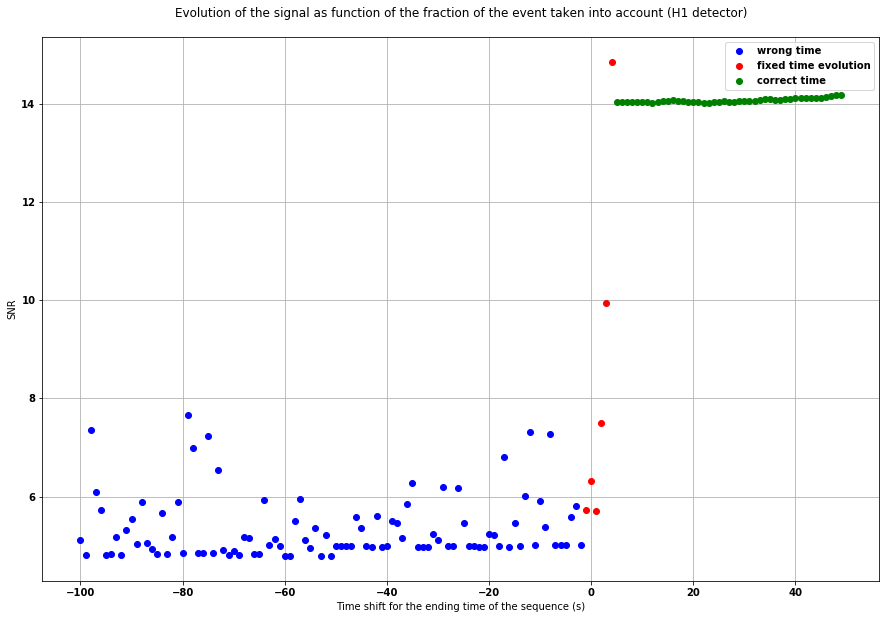

In [58]:
j = 1
l = 1
k = 1

plt.figure(figsize = [15,10])

for i in range(len(snrs)):
    if int(times[i]) == 1187008882:
        if j == 1:
            plt.plot(end_times[i], snrs[i], 'og', label= 'correct time')
            j = 12
        else:
            plt.plot(end_times[i], snrs[i], 'og')
    elif int(times[i]) == 1187008634:
        if k == 1:
            plt.plot(end_times[i], snrs[i], 'or', label = 'fixed time evolution')
            k = 12
        else:
            plt.plot(end_times[i], snrs[i], 'or')
    else:
        if l == 1:
            plt.plot(end_times[i], snrs[i], 'ob', label = 'wrong time')
            l = 12
        else:
            plt.plot(end_times[i], snrs[i], 'ob')
        

plt.title("Evolution of the signal as function of the fraction of the event taken into account (H1 detector)", 
          pad = 20)
plt.xlabel("Time shift for the ending time of the sequence (s)")
plt.ylabel("SNR")
plt.grid()
plt.legend(loc='best')

## With the data added behind

In [63]:
from pycbc.types import TimeSeries

In [64]:
#we build the noise for it with the same time than for the H1 detector

ts = read_frame("H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf",
                    'H1:LOSC-STRAIN',
                   start_time = 1187007040,
                   end_time= 1187007040 + 90,
                   check_integrity=False)
noise = highpass(ts, 15)
noise = noise.crop(4,4)
noise_array = np.array(noise)

Text(0,0.5,'Normalized amplitude')

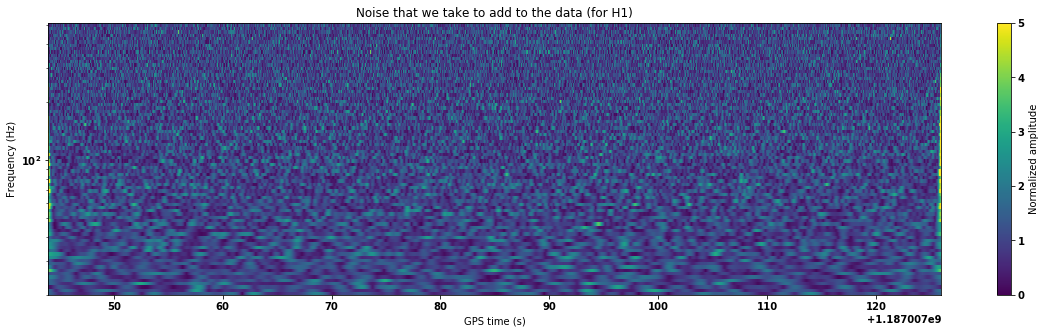

In [65]:
#check signal
t, f, p = noise.qtransform(.01, logfsteps = 100, frange = (20,1000), 
                         qrange = (110, 110))
plt.figure(figsize = [20,5])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.ylim(20,512)
plt.title("Noise that we take to add to the data (for H1)")
plt.xlabel("GPS time (s)")
plt.ylabel('Frequency (Hz)')
plt.yscale('log')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Normalized amplitude')

In [66]:
snrs_N = []
times_N = []

end_times = np.arange(-100, 50., 1)
start_times = np.arange(-356, -206, 1)

result_file = open("NS_sliding_windowSNR_withNoise_H1.txt", "w")



for i in range(len(start_times)):
    print("Itteration %i  / %i" %(i, len(end_times)))
    #download and prepare the data frame
    ts = read_frame("H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf",
                    'H1:LOSC-STRAIN',
                   start_time=merger.time + start_times[i],
                   end_time=merger.time + end_times[i],
                   check_integrity=False)
    strain = highpass(ts, 15)
    strain = strain.crop(4,4)
    
    #build the signal with the noise added
    strain_array = np.array(strain)
    sig = np.hstack((strain_array, noise_array))
    signal = TimeSeries(sig, delta_t = strain.delta_t, 
                        epoch = strain.start_time)
    
    #new data in the frequency domain
    str_freq = signal.to_frequencyseries()
    
     #psd of the data
    
    psd = signal.psd(2)
    psd = interpolate(psd, signal.delta_f)
    psd = inverse_spectrum_truncation(psd, 2*signal.sample_rate, 
                                           low_frequency_cutoff = 15.0,
                                          trunc_method = 'hann')
    
    #rebuild the template to be sure that it is the correct size
    
    hp, hc = get_fd_waveform(approximant = 'IMRPhenomD_NRTidal', 
                         mass1 = 1.5270051, mass2 = 1.2422962, 
                         spin1z = -0.015901944, spin2z = -0.035747342,
                        distance = 85.493584, coa_phase = -2.0127285,
                        f_final = 1024.0, f_lower = 20., 
                        delta_f = str_freq.delta_f)

    hp.resize(len(str_freq))
    
    #matched filtering
    snr = matched_filter(hp, str_freq, psd = psd, 
                         low_frequency_cutoff = 15.0)
    _, idx = snr.abs_max_loc()
    max_snr = snr[idx]
    snr_m = abs(max_snr)
    max_t = float(idx)/snr.sample_rate + snr.start_time
    
    snrs_N.append(snr_m)
    times_N.append(max_t)
    
    #write what is obtained into a text file
    result_file.write("start time: %i, end time: %.4f, SNR: %.7f found at time %.7f /n" %(start_times[i], (merger.time+end_times[i]), snr_m, max_t))
    
    print("Done")
    




Itteration 0  / 150
Done
Itteration 1  / 150
Done
Itteration 2  / 150
Done
Itteration 3  / 150
Done
Itteration 4  / 150
Done
Itteration 5  / 150
Done
Itteration 6  / 150
Done
Itteration 7  / 150
Done
Itteration 8  / 150
Done
Itteration 9  / 150
Done
Itteration 10  / 150
Done
Itteration 11  / 150
Done
Itteration 12  / 150
Done
Itteration 13  / 150
Done
Itteration 14  / 150
Done
Itteration 15  / 150
Done
Itteration 16  / 150
Done
Itteration 17  / 150
Done
Itteration 18  / 150
Done
Itteration 19  / 150
Done
Itteration 20  / 150
Done
Itteration 21  / 150
Done
Itteration 22  / 150
Done
Itteration 23  / 150
Done
Itteration 24  / 150
Done
Itteration 25  / 150
Done
Itteration 26  / 150
Done
Itteration 27  / 150
Done
Itteration 28  / 150
Done
Itteration 29  / 150
Done
Itteration 30  / 150
Done
Itteration 31  / 150
Done
Itteration 32  / 150
Done
Itteration 33  / 150
Done
Itteration 34  / 150
Done
Itteration 35  / 150
Done
Itteration 36  / 150
Done
Itteration 37  / 150
Done
Itteration 38  / 150
D

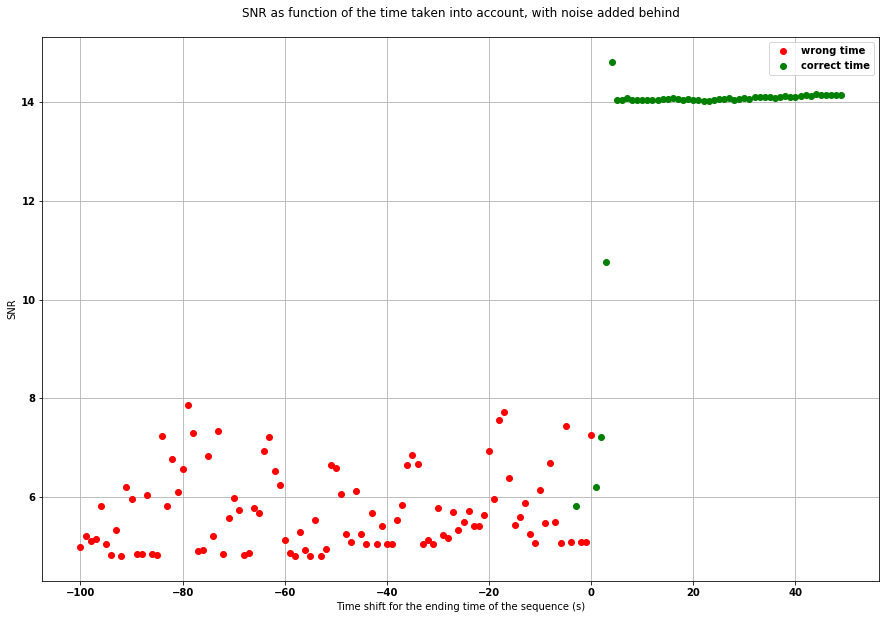

In [67]:
j = 1
k = 1

plt.figure(figsize = [15, 10])

for i in range(len(snrs)):
    if int(times_N[i]) == 1187008882 :
        if j == 1 :
            plt.plot(end_times[i], snrs_N[i], 'og', label = 'correct time')
            j = 12
        else:
            plt.plot(end_times[i], snrs_N[i], 'og')
    else:
        if k == 1:
            plt.plot(end_times[i], snrs_N[i], 'or', label = 'wrong time')
            k = 12
        else:
            plt.plot(end_times[i], snrs_N[i], 'or')
            
plt.title("SNR as function of the time taken into account, with noise added behind", 
          pad = 20)
plt.xlabel("Time shift for the ending time of the sequence (s)")
plt.ylabel("SNR")
plt.grid()
plt.legend(loc = 'best')

We see that the prediction is not possible in this case. Indeed, the event is detected only when it is fully present. However, if is seeable in the L1 detector, which means that we could maybe already send an alert.

In this case, we have taken the parameters that were found in low latency in H1. But, we found the possibility to have higher SNR in the case of only mases (adjusted in onlline test). So, we make another notebook where we test the possibility to predict in adav,ce in the case were we us these parameters.
Notebook: **NS_sliding_window__2mass.ipynb**